In [616]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [617]:
!pip install tslearn
!pip install tensorflow==1.15.0.

In [0]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from collections import defaultdict
from sklearn.model_selection import train_test_split, cross_val_score 

from sklearn.metrics import accuracy_score, f1_score, classification_report
from sklearn.metrics import roc_curve, auc, roc_auc_score


from keras.optimizers import Adagrad
from keras.optimizers import Adam
from tslearn.shapelets import ShapeletModel
from tslearn.shapelets import grabocka_params_to_shapelet_size_dict

from tslearn.preprocessing import TimeSeriesScalerMinMax

# Data Preparation

In [619]:
class_name = 'Occupancy'

dataset_path="/content/drive/Shared drives/DM2/files/combined2.csv"
df = pd.read_csv(dataset_path)

df.head()
del df['Day']
del df['TimeSlot']
del df['Weekend']
del df['WorkingHour']
del df['Date']
del df['Hour']

#df.loc[df["Occupancy"] == 1, "Occupancy"] = 'Yes'
#df.loc[df["Occupancy"] == 0, "Occupancy"] = 'No'


df = df.loc[:, ~df.columns.str.contains('^Unnamed')]


df

,Temperature,Humidity,Light,CO2,HumidityRatio,Occupancy
0,15.904468,8.698835,7.516689,5.235582,10.795786,1
1,15.957720,8.711492,7.452585,5.343291,10.831549,1
2,15.993220,8.669303,7.398537,5.432407,10.799950,1
3,15.971032,8.595474,6.654588,5.481292,10.709977,1
4,16.064222,8.648209,6.606039,5.522164,10.806016,1
...,...,...,...,...,...,...
20555,7.369492,9.715227,6.051259,12.506386,8.476117,1
20556,7.517411,9.734564,5.992341,12.595342,8.548897,1
20557,7.591371,9.734564,5.992341,12.662660,8.576488,1
20558,7.591371,9.929686,5.947562,13.725319,8.756051,1


# data transformation

In [620]:
b = df.iloc[0, 0:5].values
b

array([15.90446841,  8.69883542,  7.51668876,  5.23558227, 10.79578581])

In [621]:
#creo training set
train_x = df.iloc[0,0:5].values
for i in range (1,16380):
  #aggiungo a un array la i-esima riga
  train_x = np.append(train_x, df.iloc[i, 0:5].values)
  #print (train_x.size)
  i=i+1

#print (train_x)

print ("--- shape attuale ---")
print (train_x.shape)

print ("--- modifico shape di b ---")
train_x = train_x.reshape(273,5,60)
print (train_x.shape)
#print (train_x)

--- shape attuale ---
(81900,)
--- modifico shape di b ---
(273, 5, 60)


In [622]:
#creo il test set
test_x = df.iloc[16381,0:5].values
for i in range (16382,20521):
  #aggiungo a un array la i-esima riga
  test_x = np.append(test_x, df.iloc[i, 0:5].values)
  #print (test_x.size)
  i=i+1

#print (test_x)

print ("--- shape attuale ---")
print (test_x.shape)

print ("--- modifico shape di b ---")
test_x = test_x.reshape(69,5,60)
print (test_x.shape)
#print (test_x)







#a = df.iloc[0].values
#b = np.append(a, df.iloc[1])
#print (b)
#b.reshape(1,6,2)

--- shape attuale ---
(20700,)
--- modifico shape di b ---
(69, 5, 60)


In [623]:
#creo target per training set
import statistics

train_y = 0
temp = df.iloc[0, 5]
aux = 1

for i in range (1,16380):
  temp = np.append(temp, df.iloc[i, 5])
  #print(temp)
  if((aux % 60) == 0):
    temp.tolist
    prova = statistics.mode(temp)
    #print("media dei primi %d valori target", aux)
    train_y = np.append(train_y, prova)
    #print(prova)
    temp = 0
    prova = 0
  i = i+1
  aux = aux +1 

#print(train_y)
print(train_y.size)
print(train_y.shape)


273
(273,)


In [624]:
#creo target per test set
import statistics

test_y = 0
temp = df.iloc[16381, 5]
aux = 1

for i in range (16382,20521):
  temp = np.append(temp, df.iloc[i, 5])
  #print(temp)
  if((aux % 60) == 0):
    temp.tolist
    prova = statistics.mode(temp)
    #print("media dei primi %d valori target", aux)
    test_y = np.append(test_y, prova)
    #print(prova)
    temp = 0
    prova = 0
  i = i+1
  aux = aux +1 

#print(train_y)
print(test_y.size)
print(test_y.shape)

69
(69,)


In [625]:
print (train_x.shape, train_x.size)
print (test_x.shape, test_x.size)
print (train_y.shape, train_y.size)
print (test_y.shape, test_y.size)

print("contenuti")
print(test_y)
print(train_y)

(273, 5, 60) 81900
(69, 5, 60) 20700
(273,) 273
(69,) 69
contenuti
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0
 0 0 0 0 0 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 0 0 1 1 1 1 0 0 0 0
 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 1 1 1 1 0 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


# Multivariate Time Series Classifiers

In [626]:
!pip install pyts
!pip install tslearn

In [0]:
from pyts.datasets import load_basic_motions
from tslearn.preprocessing import TimeSeriesScalerMinMax
from sklearn.model_selection import train_test_split, cross_val_score 
from sklearn.metrics import accuracy_score, f1_score, classification_report
from sklearn.metrics import roc_curve, auc, roc_auc_score

In [0]:
#scaler = TimeSeriesScalerMinMax()
#train_x = scaler.fit_transform(train_x)
#test_x = scaler.transform(test_x)

In [629]:
train_y.shape

(273,)

In [630]:
train_y

array([0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1,
       1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0,
       1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0])

In [0]:
from sklearn.preprocessing import LabelEncoder

In [0]:
le = LabelEncoder()
train_y = le.fit_transform(train_y)
test_y = le.transform(test_y)

In [633]:
train_x = train_x.reshape(273, 60, 5)
test_x = test_x.reshape(69, 60, 5)

print (train_x.shape)
print (test_x.shape)

(273, 60, 5)
(69, 60, 5)


In [634]:
n_timesteps, n_outputs, n_features = train_x.shape[1], len(np.unique(train_y)), train_x.shape[2] 
print("TIMESTEPS: ", n_timesteps)
print("N. LABELS: ", n_outputs)
print("N. FEATURES: ", n_features)


TIMESTEPS:  60
N. LABELS:  2
N. FEATURES:  5


In [0]:
X_train_cnn, X_val_cnn, y_train_cnn, y_val_cnn = train_test_split(train_x, train_y, test_size=0.2, stratify=train_y)

In [0]:
from keras.models import Sequential
from keras.layers.core import Dense, Activation, Dropout, Flatten
from keras.layers import TimeDistributed
from keras.layers.recurrent import LSTM
from keras.layers import Dense, Conv1D, Conv2D, MaxPool2D, Flatten, Dropout, LeakyReLU, GlobalAveragePooling1D
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.layers.normalization import BatchNormalization
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint

In [0]:
def build_lstm2(n_timesteps, n_outputs, n_features):
    model = Sequential()
    model.add(LSTM(4, input_shape=(n_timesteps, n_features), return_sequences=True, 
                        kernel_initializer='TruncatedNormal'))
    model.add(BatchNormalization())
    model.add(LeakyReLU())
    model.add(Dropout(0.3))
    
    #1
    for _ in range(2):
        model.add(LSTM(4, kernel_initializer='TruncatedNormal', return_sequences=True))
        model.add(BatchNormalization())
        model.add(LeakyReLU())
        model.add(Dropout(0.04))   

    #2
    model.add(LSTM(32, kernel_initializer='TruncatedNormal', return_sequences=False))
    model.add(BatchNormalization())
    model.add(LeakyReLU())
    model.add(Dropout(0.7))
    
    #3
    for _ in range(2):
        model.add(Dense(256, kernel_initializer='TruncatedNormal'))
        model.add(BatchNormalization())
        model.add(LeakyReLU())
        model.add(Dropout(0.2))
    #4
    for _ in range(1):
        model.add(Dense(64, kernel_initializer='TruncatedNormal'))
        model.add(BatchNormalization())
        model.add(LeakyReLU())
        model.add(Dropout(0.7))

    #5
    model.add(Dense(32, kernel_initializer='TruncatedNormal'))
    model.add(BatchNormalization())
    model.add(LeakyReLU())
    model.add(Dropout(0.4))
        
    model.add(Dense(n_outputs, activation='sigmoid'))
    
    model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    return model

In [0]:
lstm2 = build_lstm2(n_timesteps, n_outputs, n_features)

In [639]:
lstm2.summary()

Model: "sequential_20"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_29 (LSTM)               (None, 60, 4)             160       
_________________________________________________________________
batch_normalization_149 (Bat (None, 60, 4)             16        
_________________________________________________________________
leaky_re_lu_134 (LeakyReLU)  (None, 60, 4)             0         
_________________________________________________________________
dropout_149 (Dropout)        (None, 60, 4)             0         
_________________________________________________________________
lstm_30 (LSTM)               (None, 60, 4)             144       
_________________________________________________________________
batch_normalization_150 (Bat (None, 60, 4)             16        
_________________________________________________________________
leaky_re_lu_135 (LeakyReLU)  (None, 60, 4)           

In [0]:
rlr = ReduceLROnPlateau(monitor='loss', factor=0.5, patience=50, min_lr=0.0001)
mc = ModelCheckpoint('best_model_lstm2.h5', monitor='val_loss', save_best_only=True)

callbacks = [rlr, mc]

batch_size = 16
mini_batch_size = int(min(train_x.shape[0]/10, batch_size))

In [641]:
history_lstm2 = lstm2.fit(X_train_cnn, y_train_cnn, epochs=100, batch_size=mini_batch_size, callbacks=callbacks,
                          validation_data=(X_val_cnn, y_val_cnn)).history

Train on 218 samples, validate on 55 samples
Epoch 1/100
218/218 [==============================] - 9s 42ms/step - loss: 0.6986 - accuracy: 0.6422 - val_loss: 0.6814 - val_accuracy: 0.7636
Epoch 2/100
218/218 [==============================] - 1s 7ms/step - loss: 0.5687 - accuracy: 0.7202 - val_loss: 0.6647 - val_accuracy: 0.7636
Epoch 3/100
218/218 [==============================] - 1s 6ms/step - loss: 0.5313 - accuracy: 0.7385 - val_loss: 0.6467 - val_accuracy: 0.7636
Epoch 4/100
218/218 [==============================] - 1s 6ms/step - loss: 0.4285 - accuracy: 0.8440 - val_loss: 0.6253 - val_accuracy: 0.7636
Epoch 5/100
218/218 [==============================] - 1s 6ms/step - loss: 0.4752 - accuracy: 0.8394 - val_loss: 0.6035 - val_accuracy: 0.7636
Epoch 6/100
218/218 [==============================] - 2s 7ms/step - loss: 0.4005 - accuracy: 0.8578 - val_loss: 0.5876 - val_accuracy: 0.7636
Epoch 7/100
218/218 [==============================] - 1s 6ms/step - loss: 0.3856 - accuracy: 0.

In [642]:
y_pred = np.argmax(lstm2.predict(test_x), axis=1)

print('Accuracy %s' % accuracy_score(test_y, y_pred))
print('F1-score %s' % f1_score(test_y, y_pred, average=None))
print(classification_report(test_y, y_pred))

Accuracy 0.9420289855072463
F1-score [0.96       0.89473684]
              precision    recall  f1-score   support

           0       0.98      0.94      0.96        51
           1       0.85      0.94      0.89        18

    accuracy                           0.94        69
   macro avg       0.91      0.94      0.93        69
weighted avg       0.95      0.94      0.94        69



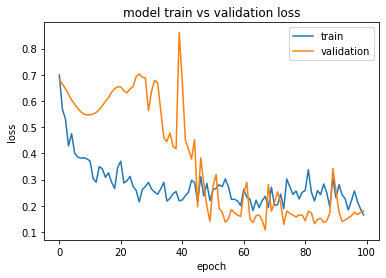

In [643]:
from matplotlib import pyplot
pyplot.plot(history_lstm2['loss'])
pyplot.plot(history_lstm2['val_loss'])
pyplot.title('model train vs validation loss')
pyplot.ylabel('loss')
pyplot.xlabel('epoch')
pyplot.legend(['train', 'validation'], loc='upper right')
pyplot.show()

In [644]:
X_train_cnn.shape

(218, 60, 5)

In [645]:
X_train_cnn2 = X_train_cnn.reshape(X_train_cnn.shape[0], X_train_cnn.shape[1], X_train_cnn.shape[2], 1)
X_val_cnn2 = X_val_cnn.reshape(X_val_cnn.shape[0], X_val_cnn.shape[1], X_val_cnn.shape[2], 1)
X_test_cnn2 = test_x.reshape(test_x.shape[0], test_x.shape[1], test_x.shape[2], 1)

X_train_cnn2.shape

(218, 60, 5, 1)

In [0]:
def build_cnn2(n_timesteps, n_features, n_outputs):
    input_shape = (n_timesteps, n_features, 1)

    model = Sequential()
    
    ks1_first = 3
    ks1_second = 3
    
    ks2_first = 4
    ks2_second = 4
    
    model.add(Conv2D(filters=(3), 
                     kernel_size=(ks1_first, ks1_second),
                     input_shape=input_shape, 
                     padding='same',
                     kernel_initializer='TruncatedNormal'))
    model.add(BatchNormalization())
    model.add(LeakyReLU())
    model.add(Dropout(0.02))
    
    for _ in range(2):
        model.add(Conv2D(filters=(4), 
                     kernel_size= (ks2_first, ks2_second), 
                         padding='same',
                     kernel_initializer='TruncatedNormal'))
        model.add(BatchNormalization())
        model.add(LeakyReLU())
        model.add(Dropout(0.2))  
    
    model.add(Flatten())
    
    for _ in range(4):
        model.add(Dense(64 , kernel_initializer='TruncatedNormal'))
        model.add(BatchNormalization())
        model.add(LeakyReLU())
        model.add(Dropout(0.4))
    
    for _ in range(3):
        model.add(Dense(128 , kernel_initializer='TruncatedNormal'))
        model.add(BatchNormalization())
        model.add(LeakyReLU())
        model.add(Dropout(0.3))
  
    model.add(Dense(1024 , kernel_initializer='TruncatedNormal'))
    model.add(BatchNormalization())
    model.add(LeakyReLU())
    model.add(Dropout(0.7))
        
    model.add(Dense(n_outputs, activation='sigmoid'))
    model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    return model

In [0]:
cnn2 = build_cnn2(n_timesteps, n_features, n_outputs)

In [648]:
cnn2.summary()

Model: "sequential_21"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_22 (Conv2D)           (None, 60, 5, 3)          30        
_________________________________________________________________
batch_normalization_157 (Bat (None, 60, 5, 3)          12        
_________________________________________________________________
leaky_re_lu_142 (LeakyReLU)  (None, 60, 5, 3)          0         
_________________________________________________________________
dropout_157 (Dropout)        (None, 60, 5, 3)          0         
_________________________________________________________________
conv2d_23 (Conv2D)           (None, 60, 5, 4)          196       
_________________________________________________________________
batch_normalization_158 (Bat (None, 60, 5, 4)          16        
_________________________________________________________________
leaky_re_lu_143 (LeakyReLU)  (None, 60, 5, 4)        

In [0]:
rlr = ReduceLROnPlateau(monitor='loss', factor=0.5, patience=50, min_lr=0.0001)
mc = ModelCheckpoint('best_model_cnn2.h5', monitor='val_loss', save_best_only=True)

callbacks = [rlr, mc]

batch_size = 16
mini_batch_size = int(min(X_train.shape[0]/10, batch_size))

In [650]:
history_cnn2 = cnn2.fit(X_train_cnn2, y_train_cnn, epochs=100, batch_size=mini_batch_size, callbacks=callbacks,
                      validation_data=(X_val_cnn2, y_val_cnn)).history

Train on 218 samples, validate on 55 samples
Epoch 1/100
218/218 [==============================] - 9s 43ms/step - loss: 0.6881 - accuracy: 0.6697 - val_loss: 0.6288 - val_accuracy: 0.7636
Epoch 2/100
218/218 [==============================] - 1s 6ms/step - loss: 0.6853 - accuracy: 0.7018 - val_loss: 0.6157 - val_accuracy: 0.7636
Epoch 3/100
218/218 [==============================] - 1s 6ms/step - loss: 0.6011 - accuracy: 0.7064 - val_loss: 0.6344 - val_accuracy: 0.7636
Epoch 4/100
218/218 [==============================] - 1s 6ms/step - loss: 0.5080 - accuracy: 0.7339 - val_loss: 0.6144 - val_accuracy: 0.7636
Epoch 5/100
218/218 [==============================] - 1s 6ms/step - loss: 0.5713 - accuracy: 0.7477 - val_loss: 0.5965 - val_accuracy: 0.7636
Epoch 6/100
218/218 [==============================] - 1s 6ms/step - loss: 0.5204 - accuracy: 0.7523 - val_loss: 0.4969 - val_accuracy: 0.7636
Epoch 7/100
218/218 [==============================] - 1s 6ms/step - loss: 0.4983 - accuracy: 0.

In [651]:
y_pred = np.argmax(cnn2.predict(X_test_cnn2), axis=1)

print('Accuracy %s' % accuracy_score(test_y, y_pred))
print('F1-score %s' % f1_score(test_y, y_pred, average=None))
print(classification_report(test_y, y_pred))

Accuracy 0.7391304347826086
F1-score [0.85 0.  ]
              precision    recall  f1-score   support

           0       0.74      1.00      0.85        51
           1       0.00      0.00      0.00        18

    accuracy                           0.74        69
   macro avg       0.37      0.50      0.42        69
weighted avg       0.55      0.74      0.63        69



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


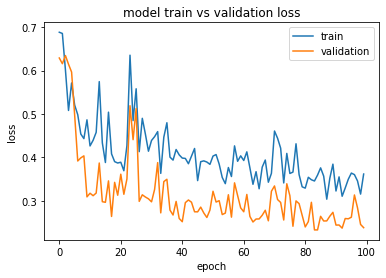

In [652]:
from matplotlib import pyplot
pyplot.plot(history_cnn2['loss'])
pyplot.plot(history_cnn2['val_loss'])
pyplot.title('model train vs validation loss')
pyplot.ylabel('loss')
pyplot.xlabel('epoch')
pyplot.legend(['train', 'validation'], loc='upper right')
pyplot.show()

In [0]:
def build_cnn3(n_timesteps, n_outputs, n_features):
    model = Sequential()
    
    model.add(Conv1D(filters=16, kernel_size=8, activation='relu', input_shape=(n_timesteps, n_features)))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    
    model.add(Dropout(0.3))
    
    model.add(Conv1D(filters=32, kernel_size=5, activation='relu'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    
    model.add(Dropout(0.3))
    
    model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    
    model.add(Dropout(0.3))
    
    model.add(GlobalAveragePooling1D())
    
    model.add(Dense(n_outputs, activation='sigmoid'))
    model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    return model

In [0]:
cnn3 = build_cnn3(n_timesteps, n_outputs, n_features)

In [655]:
cnn3.summary()

Model: "sequential_22"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_16 (Conv1D)           (None, 53, 16)            656       
_________________________________________________________________
batch_normalization_168 (Bat (None, 53, 16)            64        
_________________________________________________________________
activation_16 (Activation)   (None, 53, 16)            0         
_________________________________________________________________
dropout_168 (Dropout)        (None, 53, 16)            0         
_________________________________________________________________
conv1d_17 (Conv1D)           (None, 49, 32)            2592      
_________________________________________________________________
batch_normalization_169 (Bat (None, 49, 32)            128       
_________________________________________________________________
activation_17 (Activation)   (None, 49, 32)          

In [0]:
rlr = ReduceLROnPlateau(monitor='loss', factor=0.5, patience=50, min_lr=0.0001)
mc = ModelCheckpoint('best_model_cnn2.h5', monitor='val_loss', save_best_only=True)

callbacks = [rlr, mc]

batch_size = 16
mini_batch_size = int(min(X_train.shape[0]/10, batch_size))

In [657]:
history_cnn3 = cnn3.fit(X_train_cnn, y_train_cnn, epochs=100, batch_size=mini_batch_size, callbacks=callbacks,
                      validation_data=(X_val_cnn, y_val_cnn)).history

Train on 218 samples, validate on 55 samples
Epoch 1/100
218/218 [==============================] - 6s 27ms/step - loss: 0.5321 - accuracy: 0.7844 - val_loss: 0.8482 - val_accuracy: 0.2364
Epoch 2/100
218/218 [==============================] - 1s 4ms/step - loss: 0.4612 - accuracy: 0.7936 - val_loss: 0.5087 - val_accuracy: 0.9455
Epoch 3/100
218/218 [==============================] - 1s 4ms/step - loss: 0.2916 - accuracy: 0.8945 - val_loss: 0.3680 - val_accuracy: 0.9273
Epoch 4/100
218/218 [==============================] - 1s 4ms/step - loss: 0.3443 - accuracy: 0.8670 - val_loss: 0.4143 - val_accuracy: 0.8727
Epoch 5/100
218/218 [==============================] - 1s 4ms/step - loss: 0.3734 - accuracy: 0.8624 - val_loss: 0.4566 - val_accuracy: 0.8364
Epoch 6/100
218/218 [==============================] - 1s 3ms/step - loss: 0.3126 - accuracy: 0.8716 - val_loss: 0.4162 - val_accuracy: 0.8364
Epoch 7/100
218/218 [==============================] - 1s 3ms/step - loss: 0.3359 - accuracy: 0.

In [658]:
y_pred = np.argmax(cnn3.predict(test_x), axis=1)

print('Accuracy %s' % accuracy_score(test_y, y_pred))
print('F1-score %s' % f1_score(test_y, y_pred, average=None))
print(classification_report(test_y, y_pred))

Accuracy 0.7681159420289855
F1-score [0.81395349 0.69230769]
              precision    recall  f1-score   support

           0       1.00      0.69      0.81        51
           1       0.53      1.00      0.69        18

    accuracy                           0.77        69
   macro avg       0.76      0.84      0.75        69
weighted avg       0.88      0.77      0.78        69



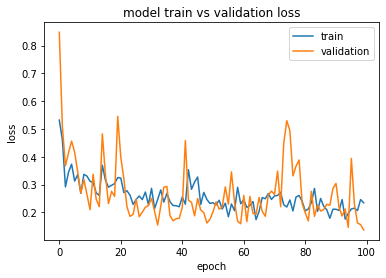

In [659]:
from matplotlib import pyplot
pyplot.plot(history_cnn3['loss'])
pyplot.plot(history_cnn3['val_loss'])
pyplot.title('model train vs validation loss')
pyplot.ylabel('loss')
pyplot.xlabel('epoch')
pyplot.legend(['train', 'validation'], loc='upper right')
pyplot.show()